In [1]:
# Build the neural network
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple, deque
import gymnasium as gym
import os

dir = "trained_agents"
if not os.path.exists(dir):
    os.makedirs(dir)

class DQNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, action_dim)
        
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [2]:
class ReplayMemory():
    def __init__(self, maxlen):
        self.memory = deque([], maxlen=maxlen)
    
    def append(self, transition):
        self.memory.append(transition)

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)  
    
    def __len__(self):
        return len(self.memory)


In [3]:
class FrozenLake():
    # Hyperparameters
    lr = 0.003  # Learning rate
    epsilon_rate = 1.0  # Exploration rate
    epsilon_min = 0.1
    epsilon_decay = 0.998
    gamma = 0.9  # Discount factor
    update_rate = 10  # Update target network every 10 episodes
    replay_memory_size = 1000  # Replay memory size
    batch_size = 64  # Number of samples to take from replay memory
    checkpoint_episode = 200  # Save model checkpoint every 100 episodes

    ACTIONS = ['L', 'D', 'R', 'U']  # Left, Down, Right, Up

    def train(self, episodes, render=False, is_slippery=False):
        env = gym.make('FrozenLake-v1', map_name='4x4', is_slippery=is_slippery, render_mode='human' if render else None)
        states = env.observation_space.n
        actions = env.action_space.n

        memory = ReplayMemory(self.replay_memory_size)

        policy_net = DQNetwork(states, actions)
        target_net = DQNetwork(states, actions)

        target_net.load_state_dict(policy_net.state_dict())

        print('Training on', 'slippery' if is_slippery else 'non-slippery', 'FrozenLake')

        self.loss_fn = nn.MSELoss()
        self.optimizer = optim.Adam(policy_net.parameters(), lr=self.lr)

        rewards_per_episode = np.zeros(episodes + 1)

        epsilon_rate_history = []
        returns = []  # List to store returns for each episode

        steps = 0

        for episode in range(1, episodes + 1):  # Loop through episodes
            state = env.reset()[0]
            done = False  # True if agent stepped on a hole or reached the goal
            stop = False  # True if agent takes too long to solve the environment
            total_reward = 0

            while not done and not stop:
                # Epsilon_rate-greedy policy
                if random.random() < self.epsilon_rate:
                    # take a random action
                    action = env.action_space.sample()
                else:
                    # take the action with the highest Q-value
                    with torch.no_grad():  # Disable gradient tracking since we are not training
                        action = policy_net(self.state_to_dqn_input(state, states)).argmax().item()

                new_state, reward, done, _, _ = env.step(action)
                memory.append((state, action, reward, new_state, done))

                state = new_state
                total_reward += reward
                steps += 1

            rewards_per_episode[episode] = total_reward
            returns.append(total_reward)  # Track the return

            if len(memory) >= self.batch_size and np.sum(rewards_per_episode) > 0:
                batch = memory.sample(self.batch_size)  # Sample a batch of transitions
                self.optimize(batch, policy_net, target_net)  # Optimize the policy network passing the batch

            if self.epsilon_rate > self.epsilon_min:
                self.epsilon_rate *= self.epsilon_decay
                epsilon_rate_history.append(self.epsilon_rate)

                if steps > self.update_rate:
                    target_net.load_state_dict(policy_net.state_dict())
                    steps = 0

            if done:
                print(f"episode: {episode}/{episodes}, return: {rewards_per_episode[episode]}, epsilon: {self.epsilon_rate:.2f}")

            if episode % self.checkpoint_episode == 0:
                torch.save(policy_net.state_dict(), f"trained_agents/policy_net{episode}.pth")

        env.close()
        return returns

    def optimize(self, batch, policy_net, target_net):
        states = policy_net.fc1.in_features
        current_q_list = []
        target_q_list = []

        for state, action, reward, new_state, done in batch:
            if done:
                # If the episode is done, the target is the reward (0 if the agent fell in a hole, 1 if it reached the goal)
                target = torch.FloatTensor([reward])
            else:
                # Calculate target q value
                with torch.no_grad():
                    target = torch.FloatTensor(
                        reward + self.gamma * target_net(self.state_to_dqn_input(new_state, states)).max()
                    )

            # Get the current set of Q values
            current_q = policy_net(self.state_to_dqn_input(state, states))
            current_q_list.append(current_q)

            # Get the target set of Q values
            target_q = target_net(self.state_to_dqn_input(state, states))
            # Adjust the specific action to the target that was just calculated.
            # Target_q[batch][action], hardcode batch to 0 because there is only 1 batch.
            target_q[action] = target
            target_q_list.append(target_q)

        # Compute loss for the whole minibatch
        loss = self.loss_fn(torch.stack(current_q_list), torch.stack(target_q_list))

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def state_to_dqn_input(self, state: int, states: int) -> torch.Tensor:
        # One hot encode the state
        state_onehot = torch.zeros(states)
        state_onehot[state] = 1
        return state_onehot

    def test(self, episodes, render=True, is_slippery=False):
        # Create FrozenLake instance
        env = gym.make('FrozenLake-v1', map_name="4x4", is_slippery=is_slippery, render_mode='human')
        num_states = env.observation_space.n
        num_actions = env.action_space.n

        # Load learned policy
        policy_net = DQNetwork(num_states, num_actions)
        policy_net.load_state_dict(torch.load("trained_agents/policy_net2000.pth"))
        policy_net.eval()  # switch model to evaluation mode

        for i in range(1, episodes + 1):
            state = env.reset()[0]  # Initialize to state 0
            done = False  # True when agent falls in hole or reached goal
            stop = False  # True when agent takes more than 200 actions
            print(f"Episode {i}/{episodes}")

            # Agent navigates map until it falls into a hole (terminated), reaches goal (terminated), or has taken 200 actions (truncated).
            while not done and not stop:
                # Select best action
                with torch.no_grad():
                    action = policy_net(self.state_to_dqn_input(state, num_states)).argmax().item()

                # Execute action
                state, reward, done, stop, _ = env.step(action)

                if reward == 1:
                    print("Goal reached!")
        

        env.close()


Training on non-slippery FrozenLake
episode: 1/2000, return: 0.0, epsilon: 1.00
episode: 2/2000, return: 0.0, epsilon: 1.00
episode: 3/2000, return: 0.0, epsilon: 0.99
episode: 4/2000, return: 1.0, epsilon: 0.99
episode: 5/2000, return: 0.0, epsilon: 0.99
episode: 6/2000, return: 0.0, epsilon: 0.99
episode: 7/2000, return: 0.0, epsilon: 0.99
episode: 8/2000, return: 0.0, epsilon: 0.98
episode: 9/2000, return: 0.0, epsilon: 0.98
episode: 10/2000, return: 0.0, epsilon: 0.98
episode: 11/2000, return: 0.0, epsilon: 0.98
episode: 12/2000, return: 0.0, epsilon: 0.98
episode: 13/2000, return: 0.0, epsilon: 0.97
episode: 14/2000, return: 0.0, epsilon: 0.97
episode: 15/2000, return: 0.0, epsilon: 0.97
episode: 16/2000, return: 0.0, epsilon: 0.97
episode: 17/2000, return: 0.0, epsilon: 0.97
episode: 18/2000, return: 0.0, epsilon: 0.96
episode: 19/2000, return: 0.0, epsilon: 0.96
episode: 20/2000, return: 0.0, epsilon: 0.96
episode: 21/2000, return: 0.0, epsilon: 0.96
episode: 22/2000, return: 0.

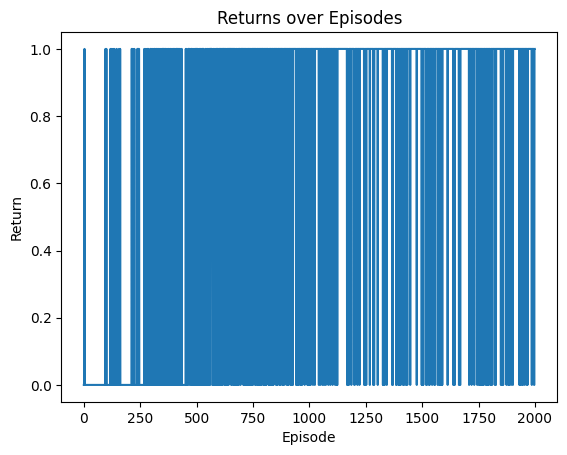

In [4]:
# Train the model and get returns
fl = FrozenLake()
returns = fl.train(episodes=2000, render=False, is_slippery=False)

# Plot the returns
plt.plot(returns)
plt.xlabel('Episode')
plt.ylabel('Return')
plt.title('Returns over Episodes')
plt.show()

print("Rate of success: ", sum(returns)/len(returns))

In [6]:
# Test the model
fl.test(episodes=10, render=True, is_slippery=False)

Episode 1/10
Goal reached!
Episode 2/10
Goal reached!
Episode 3/10
Goal reached!
Episode 4/10
Goal reached!
Episode 5/10
Goal reached!
Episode 6/10
Goal reached!
Episode 7/10
Goal reached!
Episode 8/10
Goal reached!
Episode 9/10
Goal reached!
Episode 10/10
Goal reached!


# FrozenLake using a CNN

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple, deque
import gymnasium as gym
import os
import math

# Define model
class DQCNN(nn.Module):
    def __init__(self, input_shape, out_actions):
        super().__init__()

        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=10, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.conv_block2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.layer_stack = nn.Sequential(
            nn.Flatten(), # flatten inputs into a single vector
            # After flattening the matrix into a vector, pass it to the output layer. To determine the input shape, use the print() statement in forward()
            nn.Linear(in_features=10*1*1, out_features=out_actions)
        )

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        # print(x.shape)  # Use this to determine input shape of the output layer.
        x = self.layer_stack(x)
        return x


In [13]:
class ReplayMemory():
    def __init__(self, maxlen):
        self.memory = deque([], maxlen=maxlen)

    def append(self, transition):
        self.memory.append(transition)

    def sample(self, sample_size):
        return random.sample(self.memory, sample_size)

    def __len__(self):
        return len(self.memory)

In [14]:
class FrozenLake_CNN():
    # Hyperparameters
    lr = 0.003  # Learning rate
    epsilon_rate = 1.0  # Exploration rate
    epsilon_min = 0.1
    epsilon_decay = 0.998
    gamma = 0.9  # Discount factor
    update_rate = 10  # Update target network every 10 episodes
    replay_memory_size = 1000  # Replay memory size
    batch_size = 64  # Number of samples to take from replay memory
    checkpoint_episode = 200  # Save model checkpoint every 100 episodes

    ACTIONS = ['L', 'D', 'R', 'U']  # Left, Down, Right, Up

    def train(self, episodes, render=False, is_slippery=False):
        env = gym.make('FrozenLake-v1', map_name='4x4', is_slippery=is_slippery, render_mode='human' if render else None)
        states = env.observation_space.n
        actions = env.action_space.n

        memory = ReplayMemory(self.replay_memory_size)

        policy_net = DQCNN(input_shape=3, out_actions=actions)
        target_net = DQCNN(input_shape=3, out_actions=actions)

        target_net.load_state_dict(policy_net.state_dict())

        print('Training on', 'slippery' if is_slippery else 'non-slippery', 'FrozenLake')

        self.loss_fn = nn.MSELoss()
        self.optimizer = optim.Adam(policy_net.parameters(), lr=self.lr)

        rewards_per_episode = np.zeros(episodes + 1)

        epsilon_rate_history = []
        returns = []  # List to store returns for each episode

        steps = 0

        for episode in range(1, episodes + 1):  # Loop through episodes
            state = env.reset()[0]
            done = False  # True if agent stepped on a hole or reached the goal
            stop = False  # True if agent takes too long to solve the environment
            total_reward = 0

            while not done and not stop:
                # Epsilon_rate-greedy policy
                if random.random() < self.epsilon_rate:
                    # take a random action
                    action = env.action_space.sample()
                else:
                    # take the action with the highest Q-value
                    with torch.no_grad():  # Disable gradient tracking since we are not training
                        action = policy_net(self.state_to_dqn_input(state)).argmax().item()

                new_state, reward, done, _, _ = env.step(action)
                memory.append((state, action, reward, new_state, done))

                state = new_state
                total_reward += reward
                steps += 1

            rewards_per_episode[episode] = total_reward
            returns.append(total_reward)  # Track the return

            if len(memory) >= self.batch_size and np.sum(rewards_per_episode) > 0:
                batch = memory.sample(self.batch_size)  # Sample a batch of transitions
                self.optimize(batch, policy_net, target_net)  # Optimize the policy network passing the batch

            if self.epsilon_rate > self.epsilon_min:
                self.epsilon_rate *= self.epsilon_decay
                epsilon_rate_history.append(self.epsilon_rate)

                if steps > self.update_rate:
                    target_net.load_state_dict(policy_net.state_dict())
                    steps = 0

            if done:
                print(f"episode: {episode}/{episodes}, return: {rewards_per_episode[episode]}, epsilon: {self.epsilon_rate:.2f}")

            if episode % self.checkpoint_episode == 0:
                torch.save(policy_net.state_dict(), f"trained_agents/policy_net_CNN_{episode}.pth")

        env.close()

    def optimize(self, batch, policy_net, target_net):
        states = policy_net.conv_block1[0].in_channels
        current_q_list = []
        target_q_list = []

        for state, action, reward, new_state, done in batch:
            if done:
                # If the episode is done, the target is the reward (0 if the agent fell in a hole, 1 if it reached the goal)
                target = torch.FloatTensor([reward])
            else:
                # Calculate target q value
                with torch.no_grad():
                    target = torch.FloatTensor(
                        reward + self.gamma * target_net(self.state_to_dqn_input(new_state)).max()
                    )

            # Get the current set of Q values
            current_q = policy_net(self.state_to_dqn_input(state))
            current_q_list.append(current_q)

            # Get the target set of Q values
            target_q = target_net(self.state_to_dqn_input(state))
            # Adjust the specific action to the target that was just calculated.
            # Target_q[batch][action], hardcode batch to 0 because there is only 1 batch.
            target_q[0][action] = target
            target_q_list.append(target_q)

        # Compute loss for the whole minibatch
        loss = self.loss_fn(torch.stack(current_q_list), torch.stack(target_q_list))

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def state_to_dqn_input(self, state:int)->torch.Tensor:
        '''
        Converts a state (int) to a tensor representation for input into CNN: tensor[batch][channel][row][column].
        The FrozenLake 4x4 map has 4x4=16 states numbered from 0 to 15. 
        Example:
        Input: state=1
        Return: tensor([[[[0., .9, 0., 0.],
                        [0., 0., 0., 0.],
                        [0., 0., 0., 0.],
                        [0., 0., 0., 0.]],
                        repeat above matrix 2 more times
                                        ]])
            where .9 is the normalize color code of Red
        '''
        # create empty tensor[batch][channel][row][column].
        # Converting 1 state, so batch is always 1.
        # Channels = 3, Red Green Blue (RGB).
        # FrozenLake map has 4 rows x 4 columns.
        input_tensor = torch.zeros(1,3,4,4)

        # convert state to row and column
        r=math.floor(state/4)
        c=state-r*4

        # Set color for each channel. Normalize it. The color selected here is (R,G,B) = (245,66,120)
        input_tensor[0][0][r][c] = 245/255
        input_tensor[0][1][r][c] = 66/255
        input_tensor[0][2][r][c] = 120/255
        
        # To see what the image looks like, uncomment out the following lines AND put a break point at the return statement.
        # pic = input_tensor.squeeze()      # input_tensor[batch][channel][row][column] - use squeeze to remove the batch level
        # pic = torch.movedim(pic, 0, 2)    # rearrange from [channel][row][column] to [row][column][channel]
        # plt.imshow(pic)                   # plot the image
        # plt.show()                        # show the image
        
        return input_tensor


    def test(self, episodes, render=True, is_slippery=False):
        # Create FrozenLake instance
        env = gym.make('FrozenLake-v1', map_name="4x4", is_slippery=is_slippery, render_mode='human')
        num_states = env.observation_space.n
        num_actions = env.action_space.n

        # Load learned policy
        policy_net = DQCNN(input_shape=3, out_actions=num_actions)
        policy_net.load_state_dict(torch.load("trained_agents/policy_net_CNN_2000.pth"))
        policy_net.eval()  # switch model to evaluation mode

        for i in range(1, episodes + 1):
            state = env.reset()[0]  # Initialize to state 0
            done = False  # True when agent falls in hole or reached goal
            stop = False  # True when agent takes more than 200 actions
            print(f"Episode {i}/{episodes}")

            # Agent navigates map until it falls into a hole (terminated), reaches goal (terminated), or has taken 200 actions (truncated).
            while not done and not stop:
                # Select best action
                with torch.no_grad():
                    action = policy_net(self.state_to_dqn_input(state)).argmax().item()

                # Execute action
                state, reward, done, stop, _ = env.step(action)

                if reward == 1:
                    print("Goal reached!")
        

        env.close()

In [15]:
f1 = FrozenLake_CNN()

Training on non-slippery FrozenLake
episode: 1/2000, return: 0.0, epsilon: 1.00
episode: 2/2000, return: 0.0, epsilon: 1.00
episode: 3/2000, return: 0.0, epsilon: 0.99
episode: 4/2000, return: 0.0, epsilon: 0.99
episode: 5/2000, return: 0.0, epsilon: 0.99
episode: 6/2000, return: 0.0, epsilon: 0.99
episode: 7/2000, return: 0.0, epsilon: 0.99
episode: 8/2000, return: 0.0, epsilon: 0.98
episode: 9/2000, return: 0.0, epsilon: 0.98
episode: 10/2000, return: 0.0, epsilon: 0.98
episode: 11/2000, return: 0.0, epsilon: 0.98
episode: 12/2000, return: 0.0, epsilon: 0.98
episode: 13/2000, return: 0.0, epsilon: 0.97
episode: 14/2000, return: 0.0, epsilon: 0.97
episode: 15/2000, return: 0.0, epsilon: 0.97
episode: 16/2000, return: 0.0, epsilon: 0.97
episode: 17/2000, return: 0.0, epsilon: 0.97
episode: 18/2000, return: 0.0, epsilon: 0.96
episode: 19/2000, return: 0.0, epsilon: 0.96
episode: 20/2000, return: 0.0, epsilon: 0.96
episode: 21/2000, return: 0.0, epsilon: 0.96
episode: 22/2000, return: 0.

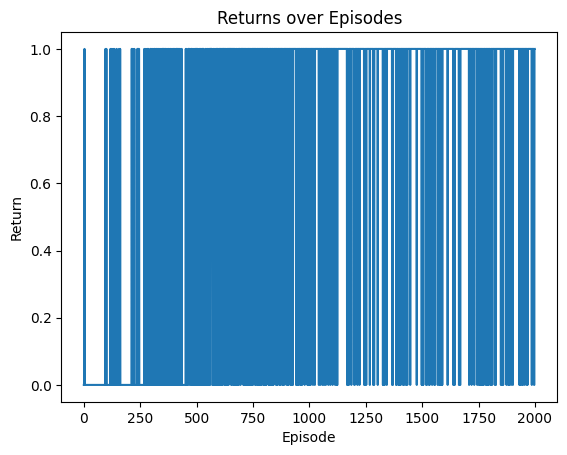

In [16]:
f1.train(episodes=2000, render=False, is_slippery=False)

# Plot the returns
plt.plot(returns)
plt.xlabel('Episode')
plt.ylabel('Return')
plt.title('Returns over Episodes')
plt.show()

print("Rate of success: ", sum(returns)/len(returns))

In [17]:
# Test the [policy_net] model
f1.test(episodes=10, render=True, is_slippery=False)

Episode 1/10
Goal reached!
Episode 2/10
Goal reached!
Episode 3/10
Goal reached!
Episode 4/10
Goal reached!
Episode 5/10
Goal reached!
Episode 6/10
Goal reached!
Episode 7/10
Goal reached!
Episode 8/10
Goal reached!
Episode 9/10
Goal reached!
Episode 10/10
Goal reached!
